In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from tqdm.auto import tqdm

### Q-Learning Method for Task 1


In [4]:
# Define the grid environment
class GridWorld:
    def __init__(self, size=5):
        self.size = size
        self.start = (4, 0)  # Start at bottom-left corner
        self.goal = (0, 4)   # End at top-right corner
        self.obstacles = [(1, 2), (2, 3), (3, 4), (3, 1)]  # Define obstacles
        self.state = self.start
        self.end_states = [self.goal]

    def reset(self):
        self.state = self.start
        return self.state

    def step(self, action):
        # Define the reward
        reward = -1
        if self.state in self.end_states:
            return self.state, reward, True

        # Calculate the next state given the action
        next_state = list(self.state)
        if action == 0:  # up
            if next_state[0] > 0:
                next_state[0] -= 1
        elif action == 1:  # down
            if next_state[0] < self.size - 1:
                next_state[0] += 1
        elif action == 2:  # left
            if next_state[1] > 0:
                next_state[1] -= 1
        elif action == 3:  # right
            if next_state[1] < self.size - 1:
                next_state[1] += 1

        # Check for obstacles
        if tuple(next_state) in self.obstacles:
            next_state = self.state

        # Check if the goal is reached
        if tuple(next_state) == self.goal:
            reward = 100

        # Update the state
        self.state = tuple(next_state)
        return self.state, reward, self.state in self.end_states

    def get_actions(self):
        return [0, 1, 2, 3]


In [5]:
# Initialize the agent's Q-table
class QLearningAgent:
    def __init__(self, env, alpha=0.1, gamma=0.6, epsilon=0.1):
        self.q_table = np.zeros((env.size, env.size, len(env.get_actions())))
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.env = env
        self.snapshots = []

    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(self.env.get_actions())  # Explore action space
        else:
            return np.argmax(self.q_table[state[0], state[1]])  # Exploit learned values

    def update_q_table(self, state, action, reward, next_state):
        old_value = self.q_table[state[0], state[1], action]
        next_max = np.max(self.q_table[next_state[0], next_state[1]])

        # Update the Q-value for the current state and action
        new_value = (1 - self.alpha) * old_value + self.alpha * (reward + self.gamma * next_max)
        self.q_table[state[0], state[1], action] = new_value


    def train(self, episodes=1000):
        for _ in tqdm(range(episodes)):
            state = self.env.reset()
            done = False

            while not done:
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(action)
                self.update_q_table(state, action, reward, next_state)
                state = next_state
            
        



In [6]:
def visualize_grid(agent, env):
    grid = np.zeros((env.size, env.size))
    for obstacle in env.obstacles:
        grid[obstacle] = -1  # Obstacles marked as -1
    grid[env.start] = 0.5  # Start marked as 0.5
    grid[env.goal] = 1  # Goal marked as 1

    # Retrieve the best path from the Q-table
    state = env.start
    path = [state]
    while state not in env.end_states:
        action = np.argmax(agent.q_table[state[0], state[1]])
        grid[state] = 0.5  # Mark the path
        if action == 0:  # up
            state = (state[0] - 1, state[1])
        elif action == 1:  # down
            state = (state[0] + 1, state[1])
        elif action == 2:  # left
            state = (state[0], state[1] - 1)
        elif action == 3:  # right
            state = (state[0], state[1] + 1)
        if state in env.obstacles:  # If the path hits an obstacle
            break
        path.append(state)

    # Display the grid
    fig, ax = plt.subplots()
    ax.matshow(grid, cmap=plt.cm.Wistia)
    ax.set_xticks(np.arange(env.size))
    ax.set_yticks(np.arange(env.size))
    ax.grid(True, which='both', color='lightgrey', linewidth=0.5)

    # Annotate the grid with start, goal, obstacles, and path
    for (j, i) in np.ndindex(grid.shape):
        if grid[i, j] == -1:
            ax.text(j, i, 'Obs', va='center', ha='center')
        elif (i, j) == env.start:
            ax.text(j, i, 'Start', va='center', ha='center')
        elif (i, j) == env.goal:
            ax.text(j, i, 'Goal', va='center', ha='center')
        elif (i, j) in path and (i, j) != env.start and (i, j) != env.goal:
            ax.text(j, i, '.', va='center', ha='center')

    plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

AttributeError: 'GridWorld' object has no attribute 'waypoints'

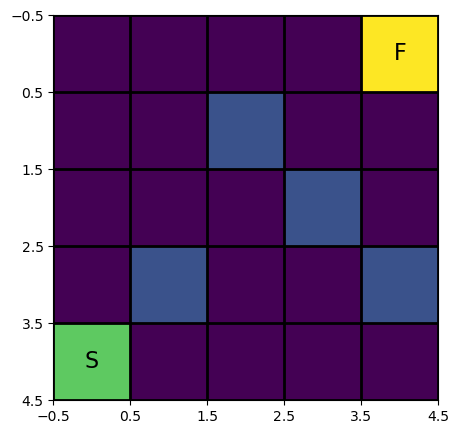

In [40]:


# Initialize the environment and agent
environment = GridWorld()
q_learning_agent = QLearningAgent(environment)

# Train the agent
q_learning_agent.train(episodes=1000)

# Visualize the grid with the path found by the Q-learning agent
visualize_grid_3(q_learning_agent, environment)


### Q-Learning Method for Task 2

In [8]:
# Define the grid environment with waypoints
class GridWorldWithWaypoints(GridWorld):
    def __init__(self, size=5):
        super().__init__(size)
        self.waypoints = [(2, 2), (1, 4)]  # Waypoints positions (green cells)
        self.waypoint_order = []  # Keep track of visited waypoints

    def step(self, action):
        next_state, reward, done = super().step(action)

        # Check if we have reached a waypoint and if it's the next one to visit
        if self.state in self.waypoints and self.state not in self.waypoint_order:
            if not self.waypoint_order or self.waypoints.index(self.state) == self.waypoint_order[-1] + 1:
                reward = 10  # Assign a positive reward for correct waypoint
                self.waypoint_order.append(self.waypoints.index(self.state))
                if len(self.waypoint_order) == len(self.waypoints):
                    done = True  # End episode when all waypoints are visited

        # Adjust reward for the final goal
        if self.state == self.goal:
            if len(self.waypoint_order) != len(self.waypoints):
                reward = -100  # Penalty for reaching the goal without all waypoints
                done = True  # End episode as this is not the correct path
            else:
                reward = 100  # Positive reward for reaching the goal after all waypoints

        return next_state, reward, done

    def reset(self):
        self.waypoint_order = []
        return super().reset()



In [15]:
class GridWorldWithWaypoints:
    def __init__(self, size=5):
        self.size = size
        self.start = (4, 0)  # Start at bottom-left corner
        self.goal = (0, 4)   # End at top-right corner
        self.obstacles = [(1, 2), (2, 3), (3, 4), (3, 1)]  # Obstacles (black cells)
        self.waypoints = [(2, 2), (1, 4)]  # Waypoints (green cells)
        self.state = self.start
        self.end_states = [self.goal]
        self.waypoint_order = []  # Keep track of visited waypoints

    def reset(self):
        self.state = self.start
        self.waypoint_order = []  # Reset the visited waypoints
        return self.state

    def step(self, action):
        if self.state in self.end_states:
            return self.state, 0, True  # No reward for staying in the goal

        # Determine next state
        row, col = self.state
        if action == 0 and row > 0:  # up
            row -= 1
        elif action == 1 and row < self.size - 1:  # down
            row += 1
        elif action == 2 and col > 0:  # left
            col -= 1
        elif action == 3 and col < self.size - 1:  # right
            col += 1
        next_state = (row, col)

        # Check for obstacles
        if next_state in self.obstacles:
            next_state = self.state  # No movement

        # Update the state
        self.state = next_state

        # Check for waypoints and goal state
        reward, done = self.evaluate_rewards_and_done()
        return self.state, reward, done

    def evaluate_rewards_and_done(self):
        reward = -1  # Default step cost
        done = False

        # Check if a waypoint is reached and it hasn't been visited yet
        if self.state in self.waypoints and self.state not in self.waypoint_order:
            self.waypoint_order.append(self.state)
            reward = 10  # Reward for visiting a waypoint

        # Check if the goal is reached
        if self.state == self.goal:
            if set(self.waypoint_order) == set(self.waypoints):
                reward = 100  # Big reward for visiting all waypoints and then reaching the goal
                done = True  # End the episode
            else:
                reward = -100  # Penalty for reaching the goal without visiting all waypoints
                done = True  # Still end the episode, but with a penalty

        return reward, done



    def get_actions(self):
        return [0, 1, 2, 3]


In [39]:
def visualize_grid_3(agent, env):
    grid = np.zeros((env.size, env.size))
    for obstacle in env.obstacles:
        grid[obstacle] = 1  # Obstacles marked as 1
    if hasattr(env, 'waypoints'):
        for waypoint in env.waypoints:
            grid[waypoint] = 2  # Waypoints marked as 2
    grid[env.start] = 3  # Start marked as 3
    grid[env.goal] = 4  # Goal marked as 4

    # Retrieve the best path from the Q-table
    state = env.start
    path = [state]
    while state not in env.end_states:
        action = np.argmax(agent.q_table[state[0], state[1]])
        next_state = (state[0], state[1])
        if action == 0 and state[0] > 0:  # up
            next_state = (state[0] - 1, state[1])
        elif action == 1 and state[0] < env.size - 1:  # down
            next_state = (state[0] + 1, state[1])
        elif action == 2 and state[1] > 0:  # left
            next_state = (state[0], state[1] - 1)
        elif action == 3 and state[1] < env.size - 1:  # right
            next_state = (state[0], state[1] + 1)

        if next_state in env.obstacles or next_state == state:
            # Break if the next state is an obstacle or the same as the current state (no movement)
            break

        path.append(next_state)
        state = next_state
        if state in env.end_states:
            break

    # Visualize the grid with the path
    fig, ax = plt.subplots(figsize=(5, 5))
    cmap = plt.cm.viridis
    norm = plt.Normalize(0, 4)
    ax.imshow(grid, cmap=cmap, norm=norm)

    # Add gridlines
    ax.grid(which='major', axis='both', linestyle='-', color='black', linewidth=2)
    ax.set_xticks(np.arange(-.5, env.size, 1))
    ax.set_yticks(np.arange(-.5, env.size, 1))

    # Draw the start and finish points
    ax.text(env.start[1], env.start[0], 'S', va='center', ha='center', color='black', fontsize=16)
    ax.text(env.goal[1], env.goal[0], 'F', va='center', ha='center', color='black', fontsize=16)

    if hasattr(env, 'waypoints'):
        # Draw the waypoints
        for waypoint in env.waypoints:
            ax.text(waypoint[1], waypoint[0], 'W', va='center', ha='center', color='black', fontsize=16)

    # Draw the arrows representing the path
    num_steps = len(path)
    colors = plt.cm.inferno(np.linspace(1, 0, num_steps))
    count = 0
    for start, end in zip(path[:-1], path[1:]):
        count += 1
        ax.annotate("", xy=(end[1], end[0]), xycoords='data',
                    xytext=(start[1], start[0]), textcoords='data',
                    arrowprops=dict(arrowstyle="->", color=colors[count], lw=1.5))

    # ax.axis('off')
    plt.show()


In [16]:
# Use the new GridWorldWithWaypoints class
env = GridWorldWithWaypoints()
agent = QLearningAgent(env)

# Train the agent
agent.train(episodes=200)



  0%|          | 0/200 [00:00<?, ?it/s]

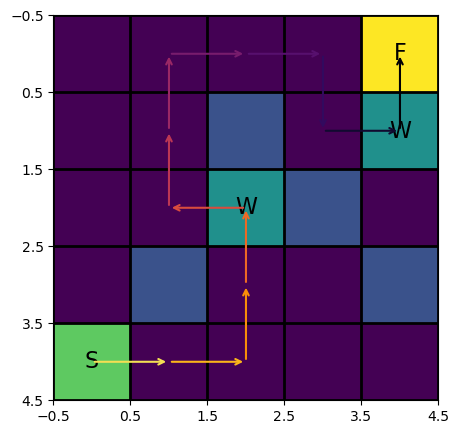

In [36]:
visualize_grid_3(agent, env)